In [40]:
import pycbc
from pycbc.waveform import get_td_waveform
from pycbc.detector import Detector
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.noise import noise_from_psd
import matplotlib.pyplot as plt

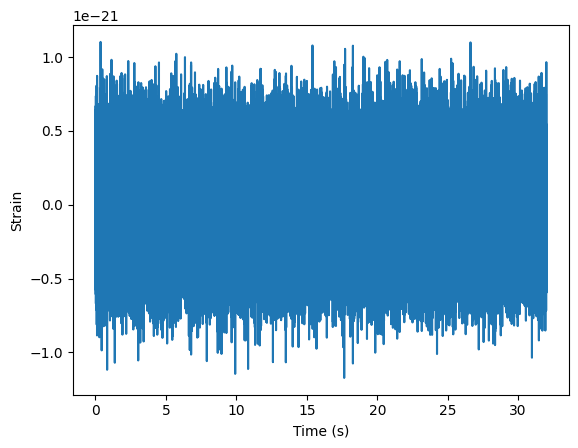

In [41]:
# The color of the noise matches a PSD which you provide
flow = 30.0
delta_f = 1.0 / 16
flen = int(2048 / delta_f) + 1
psd = aLIGOZeroDetHighPower(flen, delta_f, flow)

# Generate 32 seconds of noise at 4096 Hz
delta_t = 1.0 / 4096
tsamples = int(32 / delta_t)
ts = pycbc.noise.noise_from_psd(tsamples, delta_t, psd, seed=127)

plt.plot(ts.sample_times, ts)
plt.ylabel('Strain')
plt.xlabel('Time (s)')
plt.show()

In [42]:
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                         mass1=36, mass2=29,
                         spin1z=0.0, spin2z=0.0,
                         delta_t=1.0/4096,
                         f_lower=20.0)

det = Detector("H1")
signal = det.project_wave(hp, hc, 0,0,0)

plt.plot(signal.sample_times, signal + ts)

ValueError: different epoch, -0.759277344 vs 0

In [ ]:
from pycbc.types import TimeSeries

def add_timeseries(ts1: TimeSeries, ts2: TimeSeries, align='start') -> TimeSeries:
    """
    Add two PyCBC TimeSeries together, handling different epochs and lengths.
    
    Parameters
    ----------
    ts1 : TimeSeries
        First timeseries
    ts2 : TimeSeries
        Second timeseries (will be added to ts1)
    align : str
        How to align the timeseries. Options:
        - 'start': Align at the start (epoch)
        - 'end': Align at the end
        - 'center': Align at the center
        Default: 'start'
    
    Returns
    -------
    TimeSeries
        Sum of the two timeseries, with epoch and length from ts1
    
    Notes
    -----
    - The result will have the same length and epoch as ts1
    - ts2 will be aligned according to the 'align' parameter
    - If ts2 is shorter, zeros are used for non-overlapping regions
    - If ts2 is longer, it will be truncated
    - Both timeseries must have the same delta_t
    """
    import numpy as np
    
    # Check delta_t matches
    if ts1.delta_t != ts2.delta_t:
        raise ValueError(f'TimeSeries have different delta_t: {ts1.delta_t} vs {ts2.delta_t}')
    
    # Create output with same properties as ts1
    result = TimeSeries(np.zeros(len(ts1)), delta_t=ts1.delta_t, epoch=ts1.epoch)
    result[:] = ts1[:]
    
    # Calculate time overlap
    t1_start = float(ts1.start_time)
    t1_end = float(ts1.end_time)
    t2_start = float(ts2.start_time)
    t2_end = float(ts2.end_time)
    
    # Find overlapping region
    overlap_start = max(t1_start, t2_start)
    overlap_end = min(t1_end, t2_end)
    
    if overlap_start >= overlap_end:
        # No overlap - just return ts1
        print(f"Warning: No time overlap between series. Returning first series unchanged.")
        return result
    
    # Convert times to indices
    idx1_start = int(round((overlap_start - t1_start) / ts1.delta_t))
    idx1_end = int(round((overlap_end - t1_start) / ts1.delta_t))
    idx2_start = int(round((overlap_start - t2_start) / ts2.delta_t))
    idx2_end = int(round((overlap_end - t2_start) / ts2.delta_t))
    
    # Add overlapping region
    result[idx1_start:idx1_end] += ts2[idx2_start:idx2_end]
    
    return result


# Example usage:
# combined = add_timeseries(noise, signal)  # Signal + noise with same epoch as noise

In [ ]:
# Now fix the previous error by using the add_timeseries function
# This adds the signal to the noise, handling the different epochs

combined = add_timeseries(ts, signal)

plt.figure(figsize=(12, 4))
plt.plot(combined.sample_times, combined)
plt.ylabel('Strain')
plt.xlabel('Time (s)')
plt.title('Signal + Noise')
plt.show()

## Understanding flen and delta_f

### Key Relationship
The size of generated noise is controlled by the FFT constraint:
```
N = 1.0 / (delta_t * delta_f)
n = N // 2 + 1 ≤ flen
```

Where:
- **N** = FFT segment size (number of time samples)
- **n** = Required frequency bins
- **delta_t** = Time sampling interval (1/sample_rate)
- **delta_f** = Frequency resolution

### Why reducing delta_f increases noise size:

**delta_f is inversely related to time duration:**
```
delta_f = 1.0 / duration_in_seconds
```

- `delta_f = 1/16` → 16 second FFT segments
- `delta_f = 1/32` → 32 second FFT segments (DOUBLED!)

Smaller delta_f = finer frequency resolution = longer FFT segments = more computation

### Why increasing flen doesn't directly increase noise size:

**flen determines frequency coverage:**
```
max_frequency = (flen - 1) * delta_f
```

If you keep delta_t and delta_f constant, increasing flen just extends the PSD to higher frequencies. The noise size only changes if you then reduce delta_t to use those higher frequencies.

In [43]:
# Demonstration: How delta_f affects noise generation

print("Example 1: Current setup")
delta_f_1 = 1.0 / 16
flen_1 = int(2048 / delta_f_1) + 1
delta_t_1 = 1.0 / 4096
N_1 = int(1.0 / (delta_t_1 * delta_f_1))
n_1 = N_1 // 2 + 1

print(f"  delta_f = 1/16 = {delta_f_1:.6f} Hz")
print(f"  flen = {flen_1} frequency bins")
print(f"  delta_t = 1/4096 = {delta_t_1:.6f} seconds")
print(f"  FFT segment size N = {N_1:,} samples")
print(f"  Required freq bins n = {n_1:,}")
print(f"  Valid: n ({n_1}) ≤ flen ({flen_1})? {n_1 <= flen_1}")

print("\nExample 2: Reduce delta_f by half")
delta_f_2 = 1.0 / 32  # Halved!
flen_2 = int(2048 / delta_f_2) + 1
delta_t_2 = 1.0 / 4096  # Same
N_2 = int(1.0 / (delta_t_2 * delta_f_2))
n_2 = N_2 // 2 + 1

print(f"  delta_f = 1/32 = {delta_f_2:.6f} Hz")
print(f"  flen = {flen_2} frequency bins (DOUBLED)")
print(f"  delta_t = 1/4096 = {delta_t_2:.6f} seconds")
print(f"  FFT segment size N = {N_2:,} samples (DOUBLED!)")
print(f"  Required freq bins n = {n_2:,}")
print(f"  Valid: n ({n_2}) ≤ flen ({flen_2})? {n_2 <= flen_2}")

print("\nExample 3: Increase flen but keep delta_f constant")
delta_f_3 = 1.0 / 16  # Same as Example 1
flen_3 = int(4096 / delta_f_3) + 1  # Doubled!
delta_t_3 = 1.0 / 4096  # Same
N_3 = int(1.0 / (delta_t_3 * delta_f_3))
n_3 = N_3 // 2 + 1

print(f"  delta_f = 1/16 = {delta_f_3:.6f} Hz")
print(f"  flen = {flen_3} frequency bins (DOUBLED)")
print(f"  delta_t = 1/4096 = {delta_t_3:.6f} seconds")
print(f"  FFT segment size N = {N_3:,} samples (UNCHANGED!)")
print(f"  Required freq bins n = {n_3:,}")
print(f"  Valid: n ({n_3}) ≤ flen ({flen_3})? {n_3 <= flen_3}")
print(f"  Max frequency coverage = {(flen_3 - 1) * delta_f_3:.0f} Hz")

Example 1: Current setup
  delta_f = 1/16 = 0.062500 Hz
  flen = 32769 frequency bins
  delta_t = 1/4096 = 0.000244 seconds
  FFT segment size N = 65,536 samples
  Required freq bins n = 32,769
  Valid: n (32769) ≤ flen (32769)? True

Example 2: Reduce delta_f by half
  delta_f = 1/32 = 0.031250 Hz
  flen = 65537 frequency bins (DOUBLED)
  delta_t = 1/4096 = 0.000244 seconds
  FFT segment size N = 131,072 samples (DOUBLED!)
  Required freq bins n = 65,537
  Valid: n (65537) ≤ flen (65537)? True

Example 3: Increase flen but keep delta_f constant
  delta_f = 1/16 = 0.062500 Hz
  flen = 65537 frequency bins (DOUBLED)
  delta_t = 1/4096 = 0.000244 seconds
  FFT segment size N = 65,536 samples (UNCHANGED!)
  Required freq bins n = 32,769
  Valid: n (32769) ≤ flen (65537)? True
  Max frequency coverage = 4096 Hz
